# Sentiment Analysis of Customer Reviews: A Large Dataset

The exercise concerns classification of mobile phone reviews by the 5-star ratings, i.e. this is an ordinal classification problem. The data contains 50k reviews and is characterised by class imbalance: there are much more positive reviews than negative ones in the dataset. Review the project and write your commentary in the sections below.

Note that rather than Macroaveraged F-score, the project uses Macroaveraged RMSE ([Baccianella et al 2009](http://nmis.isti.cnr.it/sebastiani/Publications/ISDA09.pdf)) as an evaluation metric.

No code needs to be written for this exercise, but if you want to run the notebook, download the data at this [page](https://jmcauley.ucsd.edu/data/amazon/), see the file [reviews_Cell_Phones_and_Accessories_5.json.gz](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz) and put it into the same folder as the notebook.

To run the code, you may also need to first install the imblearn package:

`pip install -U imbalanced-learn`

In [1]:
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

from IPython.display import display

In [2]:
def groupby_labels(y, yhat):
    """Based on https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function
    """
    m = np.stack([y, yhat]).T
    m = m[m[:, 0].argsort()]
    grouped_preds = np.split(m[:, 1], np.unique(m[:, 0], return_index=True)[1])[1:]
    labels = np.unique(m[:, 0])
    return labels, grouped_preds

def mae_macro(y, yhat):
    """Macroaveraged MAE
    """
    labels, preds = groupby_labels(y, yhat)
    mean_diff = np.array([np.abs(label - pred).mean() for label, pred in zip(labels, preds)]).mean()
    return mean_diff

def rmse_macro(y, yhat):
    """Macroaveraged RMSE
    """
    labels, preds = groupby_labels(y, yhat)
    mean_diff = np.array([np.power(label - pred, 2).mean() for label, pred in zip(labels, preds)]).mean()
    return np.sqrt(mean_diff)

def evaluate_model(model, ytest, Xtest):
    """Given a trained model and test data, generate predictions
    and print a report with evaluation results
    """
    yhat = model.predict(Xtest)
    print(classification_report(ytest, yhat, zero_division=0))
    rmse = rmse_macro(ytest, yhat)
    print(f"{'Macro RMSE':18} {rmse:.3}")
    mae = mae_macro(ytest, yhat)
    print(f"{'Macro MAE':18} {mae:.3}")

def print_cv_results(grid_search, col_width=100, max_rows=10):
    """Given a grid search object, print a table with the 
    cross-validation results
    """
    results = pd.DataFrame(grid_search.cv_results_
                             )[['params', 'mean_train_score', 'mean_test_score']]
    
    results["mean_train_score"] = -results["mean_train_score"]
    results["mean_test_score"] = -results["mean_test_score"]
    
    results["diff, %"] = 100*(results["mean_train_score"]-results["mean_test_score"]
                                                         )/results["mean_train_score"]

    pd.set_option('display.max_colwidth', col_width)
    pd.set_option('display.min_rows', max_rows)
    pd.set_option('display.max_rows', max_rows)
    display(results.sort_values('mean_test_score', ascending=True))

In [3]:
# create a scoring function
from sklearn.metrics import make_scorer

neg_rmse_macro = make_scorer(rmse_macro, greater_is_better=False)

# Load the data

Each review is provided with with a 5 star rating, read the first 50,000 reviews. 

In [4]:
texts = []
targets = []
max_lines = 50000
lines = 0

for line in gzip.open("reviews_Cell_Phones_and_Accessories_5.json.gz", 'r'):
    d = json.loads(line)
    score = int(d['overall'])
    text = d['reviewText']
    texts.append(text)
    targets.append(score)
    
    # read the first `max_lines` reviews
    lines += 1
    if lines >= max_lines:
        break

df = pd.DataFrame({"text": texts, "target": targets})

# Training-test split

In [5]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df, test_size=0.1, stratify=df["target"], random_state=7)

# Data exploration and transformation

Check the distribution of the class label in the training data.

<AxesSubplot: >

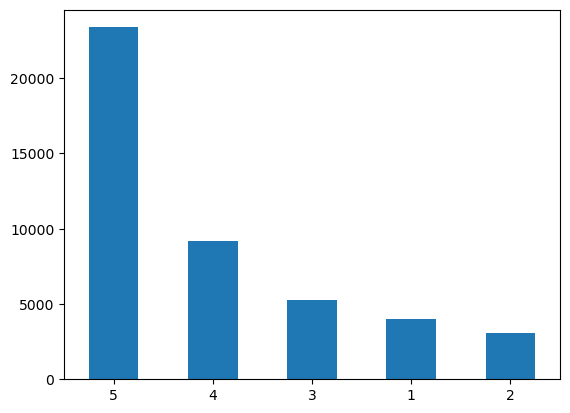

In [6]:
trainset["target"].value_counts().plot(kind="bar", rot=0)

In [7]:
Xtrain = trainset.drop("target", axis=1)
ytrain = trainset["target"].copy()

Xtest = testset.drop("target", axis=1)
ytest = testset["target"].copy()

## Construct document-by-word matrix

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    strip_accents="unicode", # convert accented chars to non-accented versions
    lowercase=True,
    tokenizer=None,        # None - use the default tokenizer
    preprocessor=None,     # None - use the default preprocessor
    stop_words="english",
    ngram_range=(1, 3),    # min and max range of ngrams
    analyzer="word",       # split the document into words, rather than e.g. characters
    max_df=0.9,            # ignore words with df greater than the value (int represents count, 
                           # float represents proportion of documents)
    min_df=10              # ignore words with df lower than the value (int represents count, 
                           # float represents proportion)
)

In [9]:
docs_train_counts = count_vectorizer.fit_transform(Xtrain['text'])
docs_train_counts.shape

(45000, 29030)

In [10]:
docs_test_counts = count_vectorizer.transform(Xtest['text'])
docs_test_counts.shape

(5000, 29030)

## TFIDF weighting of document vectors

We estimate TFIDF weights from the training data and then apply the weights both to the training and test data.

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

docs_train_tfidf = tfidf_transformer.fit_transform(docs_train_counts)
docs_test_tfidf = tfidf_transformer.transform(docs_test_counts)

After weighting, the data must be scaled.

In [12]:
from sklearn.preprocessing import MaxAbsScaler 

scaler = MaxAbsScaler()

Xtrain = scaler.fit_transform(docs_train_tfidf)
Xtest = scaler.transform(docs_test_tfidf)

# Baseline

In [13]:
trainset["target"].value_counts()

5    23378
4     9205
3     5297
1     4029
2     3091
Name: target, dtype: int64

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)
yhat_train = dummy_clf.predict(Xtrain)

evaluate_model(dummy_clf, ytrain, Xtrain)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4029
           2       0.00      0.00      0.00      3091
           3       0.00      0.00      0.00      5297
           4       0.00      0.00      0.00      9205
           5       0.52      1.00      0.68     23378

    accuracy                           0.52     45000
   macro avg       0.10      0.20      0.14     45000
weighted avg       0.27      0.52      0.36     45000

Macro RMSE         2.45
Macro MAE          2.0


# Training

## Unbalanced data

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7, max_iter=10000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10] 
}

lsvc_grid_search = GridSearchCV(lsvm, param_grid, cv=10,
                           scoring=neg_rmse_macro, #'f1_macro',
                           return_train_score=True) 
lsvc_grid_search.fit(Xtrain, ytrain)

print_cv_results(lsvc_grid_search, col_width=100, max_rows=150)

,params,mean_train_score,mean_test_score,"diff, %"
3,{'C': 1},0.170474,1.493752,-776.234672
2,{'C': 0.1},0.750984,1.524825,-103.043644
4,{'C': 10},0.086472,1.530013,-1669.383132
1,{'C': 0.01},1.727975,1.877565,-8.656981
0,{'C': 0.001},2.425778,2.428026,-0.092655


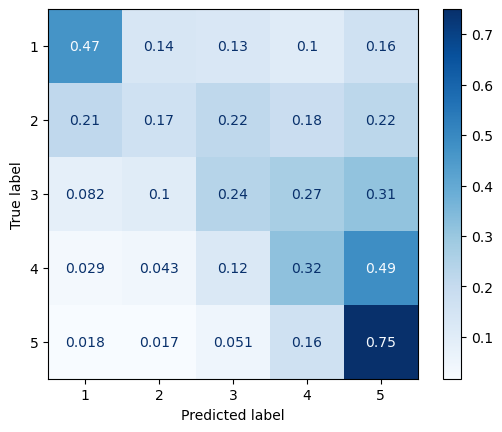

In [16]:
# cross-validation confusion matrix, training data
yhat = cross_val_predict(lsvc_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
ConfusionMatrixDisplay.from_predictions(ytrain, yhat, 
                                        labels=lsvc_grid_search.best_estimator_.classes_, 
                                        normalize="true",
                                        cmap=plt.cm.Blues);

<mark>Comment:</mark> ???

## Class balancing

In [17]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

pipeline = Pipeline([
        ('cb', RandomUnderSampler(random_state=7)),
        ('lsvc', LinearSVC(random_state=7, max_iter=10000))
    ])

param_grid = [
    {
        'cb__sampling_strategy': ["auto"],
        'lsvc__C': [0.001, 0.01, 0.1, 1, 10],
    },
]

cb_grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                              scoring=neg_rmse_macro, #'f1_macro',
                              return_train_score=True)

cb_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cb',
                                        RandomUnderSampler(random_state=7)),
                                       ('lsvc',
                                        LinearSVC(max_iter=10000,
                                                  random_state=7))]),
             param_grid=[{'cb__sampling_strategy': ['auto'],
                          'lsvc__C': [0.001, 0.01, 0.1, 1, 10]}],
             return_train_score=True,
             scoring=make_scorer(rmse_macro, greater_is_better=False))

In [18]:
print_cv_results(cb_grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
2,"{'cb__sampling_strategy': 'auto', 'lsvc__C': 0.1}",0.879395,1.292535,-46.979980
1,"{'cb__sampling_strategy': 'auto', 'lsvc__C': 0.01}",1.087488,1.302394,-19.761664
3,"{'cb__sampling_strategy': 'auto', 'lsvc__C': 1}",0.917289,1.358631,-48.113773
4,"{'cb__sampling_strategy': 'auto', 'lsvc__C': 10}",0.946738,1.380741,-45.841920
0,"{'cb__sampling_strategy': 'auto', 'lsvc__C': 0.001}",1.306560,1.403666,-7.432123


<mark>Comment:</mark> ???

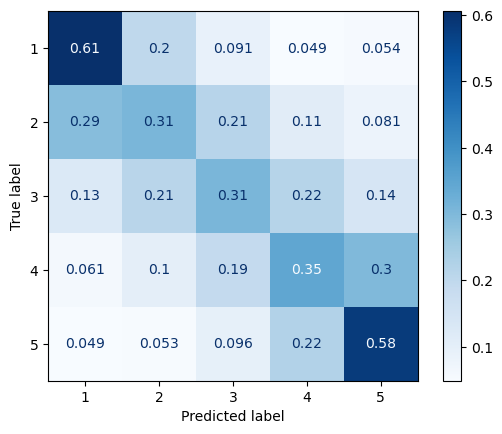

In [19]:
# cross-validation confusion matrix on the training data
yhat = cross_val_predict(cb_grid_search.best_estimator_, Xtrain, ytrain, cv=10)

ConfusionMatrixDisplay.from_predictions(ytrain, yhat, 
                                        labels=cb_grid_search.best_estimator_.classes_, 
                                        normalize="true",
                                        cmap=plt.cm.Blues);

<mark>Comment:</mark> ???

# Evaluate on test

In [20]:
# Unbalanced data
evaluate_model(lsvc_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           1       0.48      0.45      0.46       448
           2       0.23      0.19      0.21       343
           3       0.27      0.26      0.27       589
           4       0.32      0.32      0.32      1023
           5       0.70      0.74      0.72      2597

    accuracy                           0.53      5000
   macro avg       0.40      0.39      0.39      5000
weighted avg       0.52      0.53      0.52      5000

Macro RMSE         1.53
Macro MAE          1.05


In [21]:
# Class balancing
evaluate_model(cb_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

           1       0.42      0.60      0.50       448
           2       0.21      0.34      0.26       343
           3       0.24      0.31      0.27       589
           4       0.34      0.37      0.35      1023
           5       0.79      0.59      0.67      2597

    accuracy                           0.49      5000
   macro avg       0.40      0.44      0.41      5000
weighted avg       0.56      0.49      0.52      5000

Macro RMSE         1.28
Macro MAE          0.85


<mark>Comment:</mark> ???

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm